Online Kaggle training model: https://www.kaggle.com/code/naofunyannn/sic-swintransformer

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import random_split
import matplotlib.pyplot as plt
import numpy as np
import random
import os
import multiprocessing
import timm
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

**DEFINING THE MODEL**

In [2]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1) 
    return torch.tensor(torch.sum(preds == labels).item() / len(preds)) 

class ImageClassification(nn.Module): 
    def training_step(self, batch):  
        images, labels = batch
        out = self(images)  
        loss = F.cross_entropy(out, labels)
        acc = accuracy(out, labels) 
        return loss, acc

    def validating(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        acc = accuracy(out, labels)
        return {'Validation Loss': loss.detach(), 'Validation Accuracy': acc}

    def validating_epoch_final(self, outputs):
        batch_loss = [x['Validation Loss'] for x in outputs]  
        # each batch of the validation data
        epoch_loss = torch.stack(batch_loss).mean()  
        batch_accuracy = [x['Validation Accuracy'] for x in outputs]
        epoch_accuracy = torch.stack(batch_accuracy).mean()
        return {'Validation Loss': epoch_loss.item(), 'Validation Accuracy': epoch_accuracy.item()}

    def epoch_final(self, epoch, result):
        print("Epoch [{}], Training Loss: {:.4f}, Validation Loss: {:.4f}, Validation Accuracy: {:.4f}"
              .format(epoch + 1, result['Training Loss'], result['Validation Loss'], result['Validation Accuracy']))

**USING SwinTransformer FOR CLASSIFICATION**

In [3]:
class SwinTransformer(ImageClassification):
    def __init__(self):
        super().__init__()
        self.network = timm.create_model('swin_tiny_patch4_window7_224', pretrained=True, num_classes=len(garbage_classes))

    def forward(self, image):
        return self.network(image)

    def training_step(self, batch):
        images, labels = batch  
        out = self(images)  
        loss = F.cross_entropy(out, labels)  
        acc = accuracy(out, labels) 
        return loss, acc

    def epoch_final(self, epoch, result):
        print("Epoch [{}], Training Loss: {:.4f}, Training Accuracy: {:.4f}, Validation Loss: {:.4f}, Validation Accuracy: {:.4f}"
              .format(epoch + 1, result['Train Loss'], result['Train Accuracy'], result['Validation Loss'], result['Validation Accuracy']))

**EXPORT CLASSIFICATION METRICS**

In [4]:
def export_classification_metrics(model, dataloader, classes):
    model.eval()  
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in dataloader:
            images, labels = batch
            images = move_to_gpu(images, device)  
            labels = labels.to(device)  

            outputs = model(images)
            _, preds = torch.max(outputs, dim=1)

            all_preds.extend(preds.cpu().numpy())  
            all_labels.extend(labels.cpu().numpy())  

    for i, class_name in enumerate(classes):
        class_labels = [1 if label == i else 0 for label in all_labels]
        class_preds = [1 if pred == i else 0 for pred in all_preds]
        
        accuracy = accuracy_score(class_labels, class_preds) * 100
        precision = precision_score(class_labels, class_preds, zero_division=0) * 100
        recall = recall_score(class_labels, class_preds, zero_division=0) * 100
        f1 = f1_score(class_labels, class_preds, zero_division=0) * 100
        
        print(f'{class_name}, accuracy: {accuracy:.2f}%, precision: {precision:.2f}%, recall: {recall:.2f}%, F1 score: {f1:.2f}%')

**EARLY STOPPING**

In [5]:
class EarlyStopping:
    def __init__(self, patience=5, verbose=False, restore_best_weights=True):
        self.patience = patience
        self.verbose = verbose
        self.best_loss = float('inf')
        self.counter = 0
        self.early_stop = False
        self.restore_best_weights = restore_best_weights
        self.best_model_weights = None

    def __call__(self, val_loss, model):
        if val_loss < self.best_loss:
            self.best_loss = val_loss
            self.counter = 0
            if self.restore_best_weights:
                self.best_model_weights = model.state_dict().copy()
            if self.verbose:
                print(f'Validation loss improved: {val_loss:.4f}')
        else:
            self.counter += 1
            if self.verbose:
                print(f'Validation loss did not improve: {val_loss:.4f}')
            if self.counter >= self.patience:
                self.early_stop = True
                if self.restore_best_weights and self.best_model_weights is not None:
                    model.load_state_dict(self.best_model_weights)
                    if self.verbose:
                        print("Restored best model weights.")

**LOADING THE DATASET**

In [6]:
directory = '/kaggle/input/sicdataset/all_classes'
global garbage_classes
garbage_classes = os.listdir(directory)
print(garbage_classes)

['metal', 'glass', 'biological', 'paper', 'battery', 'cardboard', 'plastic']


**TRANSFORMING THE DATASETS**

In [7]:
# Importing Transforms to modify the images
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms

# Resize all images to 224x224 pixels and converting to Tensor
transformations = transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor()])

# Load the dataset and apply the transformations
dataset = ImageFolder(directory, transform=transformations)

**TESTING THE DATASETS BY RANDOMLY DISPLAYING IMAGES AND THEIR LABELS**

Label: biological (Class No: 1)


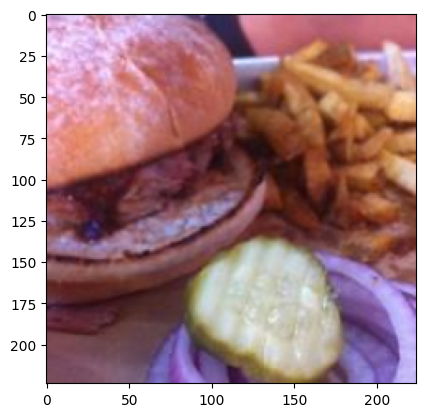

In [8]:
# Permute the dimensions of the image to fit the format of the matplotlib
def display_test(image, label):
    print("Label:", dataset.classes[label], "(Class No: " + str(label) + ")")
    plt.imshow(image.permute(1, 2, 0))
    plt.show()

# Display a random image from the dataset
image, label = dataset[random.randint(0, len(dataset))]
display_test(image, label)

**SETTING RANDOM SEED FOR REPRODUCIBILITY**

In [9]:
random_seed = 43
torch.manual_seed(random_seed)

**SPLITTING DATASET & DEFINING BATCH SIZE**

In [10]:
# Split the dataset into train, validate, and test datasets
train_size = int(0.6 * len(dataset))  # 60% of the dataset
val_size = int(0.2 * len(dataset))  # 20% of the dataset
test_size = len(dataset) - train_size - val_size  # Remaining 20% of the dataset
train_data, val_data, test_data = random_split(dataset, [train_size, val_size, test_size])
from torch.utils.data.dataloader import DataLoader
batch_size = 64

**CREATING THE DATALOADERS**

In [11]:
train = DataLoader(train_data, batch_size, shuffle=True, num_workers=4, pin_memory=True)
validation = DataLoader(val_data, batch_size * 2, num_workers=4, pin_memory=True)

**BATCH VISUALIZATION**

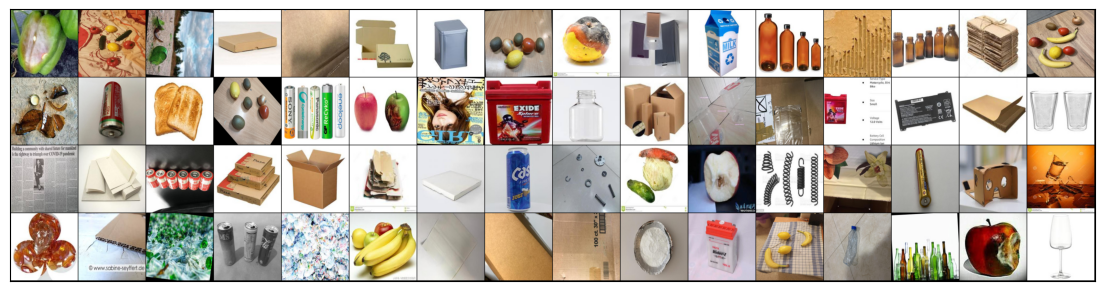

model.safetensors:   0%|          | 0.00/114M [00:00<?, ?B/s]

Processing via: cuda


SwinTransformer(
  (network): SwinTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
      (norm): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
    )
    (layers): Sequential(
      (0): SwinTransformerStage(
        (downsample): Identity()
        (blocks): Sequential(
          (0): SwinTransformerBlock(
            (norm1): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
            (attn): WindowAttention(
              (qkv): Linear(in_features=96, out_features=288, bias=True)
              (attn_drop): Dropout(p=0.0, inplace=False)
              (proj): Linear(in_features=96, out_features=96, bias=True)
              (proj_drop): Dropout(p=0.0, inplace=False)
              (softmax): Softmax(dim=-1)
            )
            (drop_path1): Identity()
            (norm2): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
            (mlp): Mlp(
              (fc1): Linear(in_features=96, out_features=384, bias

In [12]:
from torchvision.utils import make_grid
def batch_visualization(data):
    for image, labels in data:
        fig, ax = plt.subplots(figsize=(14, 14))
        ax.set_xticks([]);
        ax.set_yticks([])
        ax.imshow(make_grid(image, nrow=16).permute(1, 2, 0))
        plt.show()
        break

batch_visualization(train)
model = SwinTransformer()

def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
device = get_default_device()

def move_to_gpu(data, device):
    if isinstance(data, (list, tuple)):
        return [move_to_gpu(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DataLoad():
    def __init__(self, data, device):
        self.data = data
        self.device = get_default_device()

    def __iter__(self):
        for batch in self.data:
            yield move_to_gpu(batch, self.device)

    def __len__(self):
        return len(self.data)

device = get_default_device()
print('Processing via:', device)

train = DataLoad(train, device)
validation = DataLoad(validation, device)
move_to_gpu(model, device)

**MODEL TRAINING**

In [13]:
@torch.no_grad()
def evaluate(model, validator):
    model.eval()
    outputs = [model.validating(batch) for batch in validator]
    return model.validating_epoch_final(outputs)

def opt(epochs, learning_rate, model, train_loader, validator, opt_func=torch.optim.SGD, patience = 5):
    training_history = [] 
    optimizer = opt_func(model.parameters(), learning_rate)
    early_stopping = EarlyStopping(patience=patience, verbose=True) 
    
    for epoch in range(epochs):  
        # Training Step
        model.train()  
        train_loss = []  
        train_acc = []  

        for batch in train_loader: 
            loss, acc = model.training_step(batch)  
            train_loss.append(loss)  
            train_acc.append(acc)  
            loss.backward()  
            optimizer.step()  
            optimizer.zero_grad() 

        # Validation phase
        result = evaluate(model, validator) 
        result['Train Loss'] = torch.stack(train_loss).mean().item() 
        result['Train Accuracy'] = torch.stack(train_acc).mean().item()  

        model.epoch_final(epoch, result)  
        training_history.append(result)  
        
        # Check for early stopping
        early_stopping(result['Validation Loss'], model)
        if early_stopping.early_stop:
            print("Early stopping triggered.")
            break  
        
    return training_history

model = move_to_gpu(SwinTransformer(), device)
evaluate(model, validation)

{'Validation Loss': 1.9625749588012695,
 'Validation Accuracy': 0.09134058654308319}

**DEFINING HYPERPARAMETERS**

In [14]:
epoch = 20
optimizer = torch.optim.Adam
learning_rate = 0.00005
patience = 3  # Number of epochs to wait for improvement before stopping
model_history = opt(epoch, learning_rate, model, train, validation, optimizer, patience)

Epoch [1], Training Loss: 0.2892, Training Accuracy: 0.9063, Validation Loss: 0.0778, Validation Accuracy: 0.9725
Validation loss improved: 0.0778
Epoch [2], Training Loss: 0.0638, Training Accuracy: 0.9812, Validation Loss: 0.0563, Validation Accuracy: 0.9820
Validation loss improved: 0.0563
Epoch [3], Training Loss: 0.0370, Training Accuracy: 0.9888, Validation Loss: 0.0767, Validation Accuracy: 0.9754
Validation loss did not improve: 0.0767
Epoch [4], Training Loss: 0.0227, Training Accuracy: 0.9935, Validation Loss: 0.0587, Validation Accuracy: 0.9818
Validation loss did not improve: 0.0587
Epoch [5], Training Loss: 0.0173, Training Accuracy: 0.9945, Validation Loss: 0.0688, Validation Accuracy: 0.9821
Validation loss did not improve: 0.0688
Restored best model weights.
Early stopping triggered.


**PLOTTING THE ACCURACY VS EPOCHS**

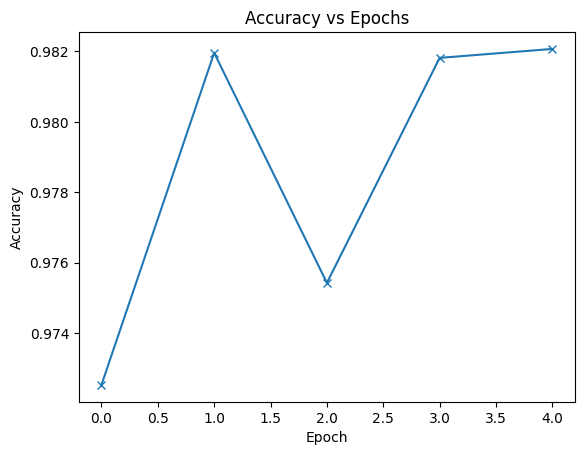

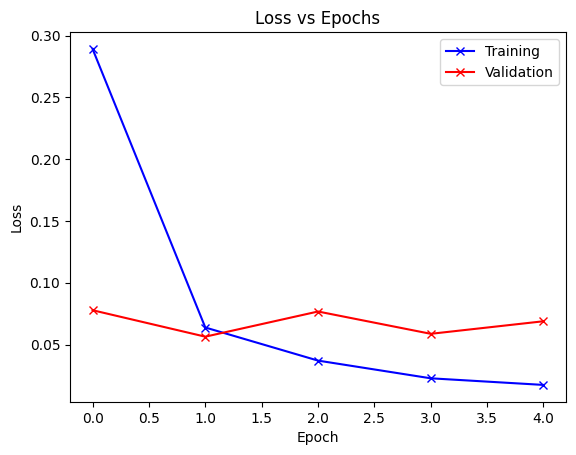

In [15]:
def plot_accuracy(model_history):
    accuracies = [x['Validation Accuracy'] for x in model_history]
    plt.plot(accuracies, '-x')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy vs Epochs')
    plt.show()
plot_accuracy(model_history)

def plot_loss(model_history):
    train_loss = [x.get('Train Loss') for x in model_history]
    validation_loss = [x['Validation Loss'] for x in model_history]
    plt.plot(train_loss, '-bx')
    plt.plot(validation_loss, '-rx')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs Epochs')
    plt.show()
plot_loss(model_history)

**PLOTTING THE CONFUSION MATRIX**

<Figure size 1000x1000 with 0 Axes>

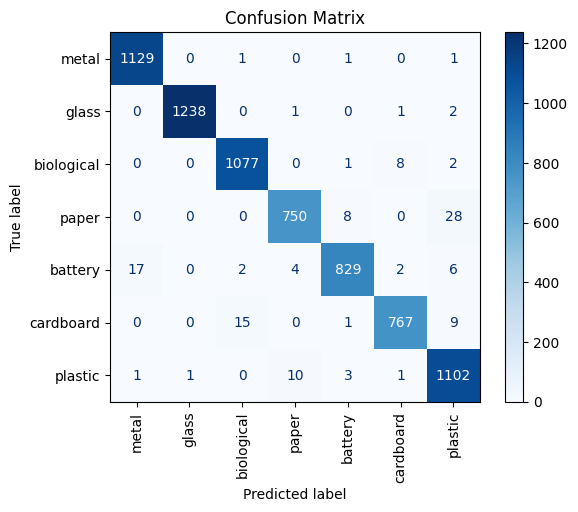

In [16]:
def plot_confusion_matrix(model, dataloader, classes):
    model.eval()  
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in dataloader:
            images, labels = batch
            images = move_to_gpu(images, device)  
            labels = labels.to(device) 

            outputs = model(images)
            _, preds = torch.max(outputs, dim=1)

            all_preds.extend(preds.cpu().numpy())  
            all_labels.extend(labels.cpu().numpy())  

    # Generate confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)

    # Plot confusion matrix
    plt.figure(figsize=(10, 10))
    disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical')
    plt.title("Confusion Matrix")
    plt.show()
plot_confusion_matrix(model, validation, garbage_classes)

In [17]:
export_classification_metrics(model, validation, garbage_classes)

metal, accuracy: 99.70%, precision: 98.43%, recall: 99.73%, F1 score: 99.08%
glass, accuracy: 99.93%, precision: 99.92%, recall: 99.68%, F1 score: 99.80%
biological, accuracy: 99.59%, precision: 98.36%, recall: 98.99%, F1 score: 98.67%
paper, accuracy: 99.27%, precision: 98.04%, recall: 95.42%, F1 score: 96.71%
battery, accuracy: 99.36%, precision: 98.34%, recall: 96.40%, F1 score: 97.36%
cardboard, accuracy: 99.47%, precision: 98.46%, recall: 96.84%, F1 score: 97.64%
plastic, accuracy: 99.09%, precision: 95.83%, recall: 98.57%, F1 score: 97.18%


**VISUALIZE THE PREDICTIONS**

In [18]:
def predict(image, model):
    xb = move_to_gpu(image.unsqueeze(0), device)
    yb = model(xb)
    _, preds = torch.max(yb, dim=1)
    return dataset.classes[preds[0].item()]

**TESTING NO.1**

Testing No.1 - Class: biological , Predicted Class: biological


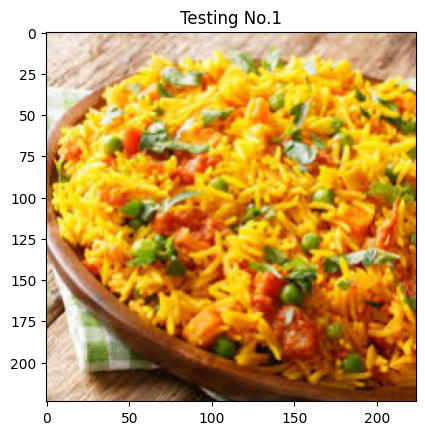

In [19]:
img, label = random.choice(dataset)
plt.imshow(img.permute(1, 2, 0))
print('Testing No.1 - Class:', dataset.classes[label], ', Predicted Class:', predict(img, model))
plt.title('Testing No.1')
plt.show()

**TESTING NO.2**

Testing No.2 - Class: plastic , Predicted Class: plastic


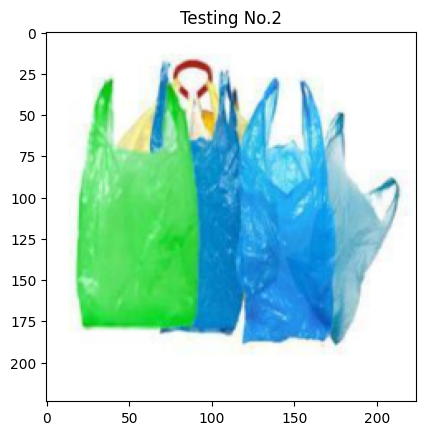

In [20]:
img, label = random.choice(dataset)
plt.imshow(img.permute(1, 2, 0)) 
print('Testing No.2 - Class:', dataset.classes[label], ', Predicted Class:', predict(img, model))
plt.title('Testing No.2')
plt.show()

**TESTING NO.3**

Testing No.3 - Class: glass , Predicted Class: glass


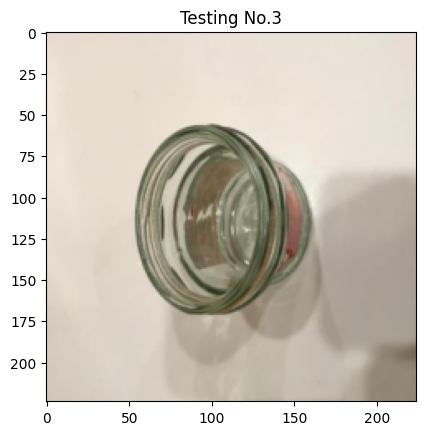

In [21]:
img, label = random.choice(dataset)
plt.imshow(img.permute(1, 2, 0)) 
print('Testing No.3 - Class:', dataset.classes[label], ', Predicted Class:', predict(img, model))
plt.title('Testing No.3')
plt.show()

**SAVING THE MODEL**

In [22]:
FILE = "/kaggle/working/SwinTransformerModel.pth"
model_scripted = torch.jit.script(model)
torch.jit.save(model_scripted, FILE)